#### We import the modules

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import xml.etree.ElementTree as ET
import operator
import pandas as pd
from functools import reduce
import re
import pandas as pd
from typing import Counter
import collections
from pandas import to_datetime

# Directory path
root_path = os.path.abspath('')

# xml file path
file_xml = os.path.join(root_path, '../datasets/posts.xml')
output = os.path.join(root_path, '../outputs/')

# Read posts.xml file
tree = ET.parse(file_xml)
root = tree.getroot()

In [8]:
def chunckify(iterable, len_of_chunk):
    for i in range(0, len(iterable), len_of_chunk):
        yield iterable[i:i + len_of_chunk]


### Top 10 least viewed posts

##### Extract the visits for each post

In [9]:
def least_viewed(data):
    # Id de cada post
    post_id = data.attrib['Id']
    # Cuenta de las vistas
    view_count = data.attrib['ViewCount']
    dictionary = {post_id: int(view_count)}
    return dictionary

##### Remove posts that have no visits "0"

In [10]:
def reduce_items(data1, data2):
    for key, value in data2.items():
        if value != 0:
            data1.update(data2)
        elif 0 in data1.values():
            data1.popitem()
    return data1

##### Returns the top 10 with the fewest visits, as a dictionary with id as key, and visits as value

In [11]:
def top10_least_viewed(data):
    s = sorted(data.items(), key=operator.itemgetter(1), reverse=False)
    d = []
    for i in range(10):
        d.append(s[i])
    return dict(d)


Define the extraction and reduction process for each data chunk

In [12]:
def mapper(data):
    post_viewd = list(map(least_viewed, data))
    reducing = reduce(reduce_items, post_viewd)
    return reducing

In [13]:
data_chunks = chunckify(root,50)

mapped = list(map(mapper, data_chunks))
reduce_mapped = reduce(reduce_items, mapped)

top10 = top10_least_viewed(reduce_mapped)

In [14]:
df = pd.DataFrame(top10.items(), columns=['Posts_id', 'Visitas'])
df.to_csv(f'{output}/GH_least_viewed_top10.csv', index=False)
df

,Posts_id,Visitas
0,617,1
1,59881,5
2,58985,7
3,60468,7
4,20024,8
5,62483,8
6,66002,8
7,55746,9
8,62204,9
9,63096,9


<AxesSubplot: xlabel='Visitas', ylabel='Posts_id'>

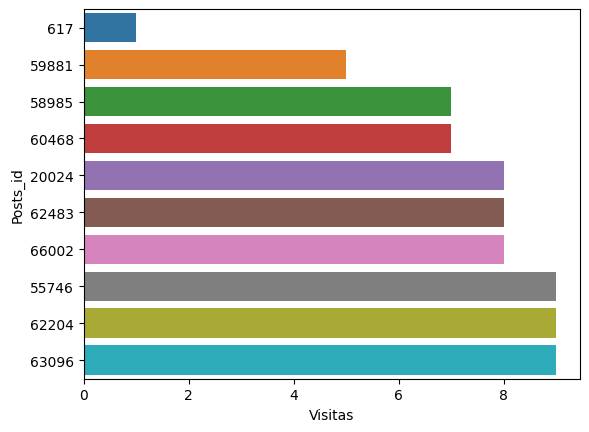

In [15]:
posts= df.Posts_id
visitas = df.Visitas

sns.barplot(x=visitas, y=posts)

### Top 10 palabras mas nombradas en los post por tipo de post

In [16]:
def words_by_type(data):
    post_type = data.attrib['PostTypeId']
    body = data.attrib['Body']
    # Get all the words of the body in a list, and remove html code using regular expression
    body = re.findall('(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))', body)
    # Count the words
    words = Counter(body)

    return post_type, words

##### Create a dictionary with post type as key and word count as value

In [17]:
def separate_by_type(data):
    return dict([[postid, data[1].copy()]for postid in data[0]])

#### To the same type of post, it joins them and updates the word counters

In [18]:
def reduce_counters(data1, data2):
    for key, value in data2.items():
        if key in data1.keys():
            data1[key].update(data2[key])
        else:
            data1.update({key:value})
        return data1

#### Get the top 10 words by post type

In [19]:
def get_top10(data):
    return data[0], data[1].most_common(10)

In [20]:
def mapper(data):
    words_count = list(map(words_by_type, data))
    words_count = list(map(separate_by_type, words_count))

    reduced = reduce(reduce_counters, words_count)

    return reduced

#### Get the dataset, apply map reduce to it, and then get the top 10 words per post type

In [21]:
data_chunks = chunckify(root, 50)

mapped = list(map(mapper, data_chunks))
reduce_mapped = reduce(reduce_counters, mapped)

top = dict(map(get_top10, reduce_mapped.items()))

In [22]:
df1 = pd.DataFrame(top.get('1'), columns=['Words', 'Count'])
df1.to_csv(f'{output}/GH_top_words_by_type_of_post_1.csv', index=False)
df1

,Words,Count
0,the,19080
1,to,13918
2,a,10950
3,I,8542
4,of,7286
5,and,7105
6,is,6280
7,that,5849
8,it,4975
9,on,4555


<AxesSubplot: xlabel='Count', ylabel='Words'>

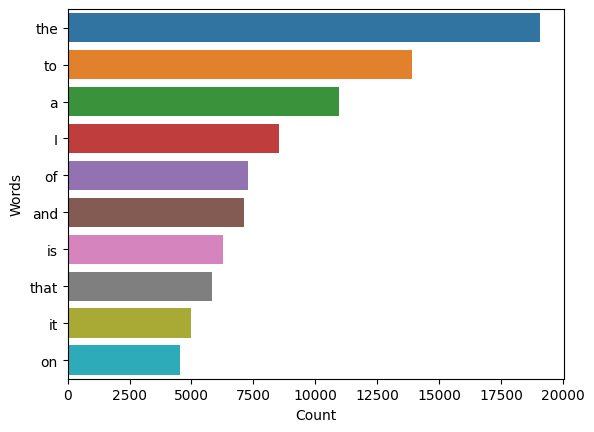

In [23]:
words1 = df1.Words
count1 = df1.Count

sns.barplot(x=count1, y=words1)

In [24]:
df2 = pd.DataFrame(top.get('2'), columns=['Words', 'Count'])
df2.to_csv(f'{output}/GH_top_words_by_type_of_post_2.csv', index=False)
df2

,Words,Count
0,the,97008
1,to,69198
2,a,54722
3,of,38350
4,and,37099
5,is,34838
6,that,31391
7,I,27097
8,you,26223
9,it,24783


<AxesSubplot: xlabel='Count', ylabel='Words'>

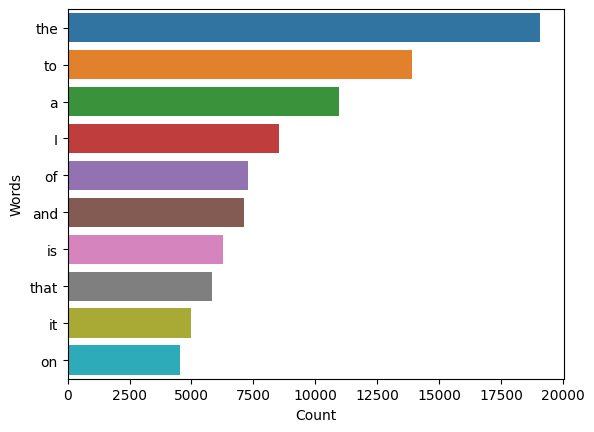

In [25]:
words2 = df2.Words
count2 = df2.Count

sns.barplot(x=count1, y=words1)

#### From the ranking of the first 300-400 by score, take the average response time and report a single value.

##### Extract the id, score, creation date, accepted Answer of each post

In [26]:
def post(data):
    post_id = data.attrib['Id']
    score = data.attrib['Score']
    creation_date = data.attrib['CreationDate']
    try:
        answer_id = data.attrib['AcceptedAnswerId']
    except:
        answer_id = None
    t = (int(score), answer_id, creation_date)
    d = {post_id: t}
    return d

#### Filter all posts that do not have an AnswerId

In [41]:
def filter_none(data):
    for key, value in data.items():
        if data== None:
            pass
        return value[1] != None

#### Ignore all posts that have a score equal to zero

In [42]:
def reduce_items(data1:dict,data2):
    if data2 != None:
        for key, value in data2.items():
            if value[0] != 0:
                data1.update(data2)
            elif 0 in data1.values():
                data1.popitem()
        return data1
    else:
        return data1

#### Apply map reduce to each data chunk

In [43]:
def mapper(data):
    post_score = list(map(post, data))
    filtering = list(filter(filter_none, post_score))
    if len(filtering) > 0:
        reduced = reduce(reduce_items, filtering)
        return reduced

#### Get the top 400 post with the highest score

In [44]:
def by_score(data):
    d = Counter(data)
    d = d.most_common(400)
    return dict(d)

#### Gets the average time a response is accepted

In [45]:
def average_time(top400):
    a = 0
    for key, value in top400.items():
        question_date = value[2]
        answer_row = root.findall(f".//row[@Id='{value[1]}']")
        answer_date = answer_row[0].attrib['CreationDate']
        a+=to_datetime(answer_date).to_numpy() - to_datetime(question_date).to_numpy()
    return int(((a/400)/10**9))/60


In [49]:
tree = ET.parse(file_xml)
root = tree.getroot()
data_chunks = chunckify(root,50)
mapped = list(map(mapper, data_chunks))
reduced = reduce(reduce_items, mapped)
top400 = by_score(reduced)
promedio = average_time(top400)
print(promedio)

39972.78333333333
